# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources in the README.md file
- Happy learning!

In [1]:
# Import your libraries:

%matplotlib inline

import numpy as np
import pandas as pd

In this lab, we will explore a dataset that describes websites with different features and labels them either benign or malicious . We will use supervised learning algorithms to figure out what feature patterns malicious websites are likely to have and use our model to predict malicious websites.

# Challenge 1 - Explore The Dataset

Let's start by exploring the dataset. First load the data file:

In [2]:
websites = pd.read_csv('../data/website.csv')
websites.head()

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,...,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
0,M0_109,16,7,iso-8859-1,nginx,263.0,None,None,10/10/2015 18:21,None,...,0,2,700,9,10,1153,832,9,2.0,1
1,B0_2314,16,6,UTF-8,Apache/2.4.10,15087.0,None,None,None,None,...,7,4,1230,17,19,1265,1230,17,0.0,0
2,B0_911,16,6,us-ascii,Microsoft-HTTPAPI/2.0,324.0,None,None,None,None,...,0,0,0,0,0,0,0,0,0.0,0
3,B0_113,17,6,ISO-8859-1,nginx,162.0,US,AK,7/10/1997 4:00,12/09/2013 0:45,...,22,3,3812,39,37,18784,4380,39,8.0,0
4,B0_403,17,6,UTF-8,None,124140.0,US,TX,12/05/1996 0:00,11/04/2017 0:00,...,2,5,4278,61,62,129889,4586,61,4.0,0


#### Explore the data from an bird's-eye view.

You should already been very familiar with the procedures now so we won't provide the instructions step by step. Reflect on what you did in the previous labs and explore the dataset.

Things you'll be looking for:

* What the dataset looks like?
* What are the data types?
* Which columns contain the features of the websites?
* Which column contains the feature we will predict? What is the code standing for benign vs malicious websites?
* Do we need to transform any of the columns from categorical to ordinal values? If so what are these columns?

Feel free to add additional cells for your explorations. Make sure to comment what you find out.

In [3]:
# how does the dataset look it?
websites.shape

(1781, 21)

In [4]:

websites.describe()

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CONTENT_LENGTH,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
count,1781.000000,1781.000000,969.000000,1781.000000,1781.000000,1781.000000,1.781000e+03,1781.000000,1781.000000,1.781000e+03,1.781000e+03,1781.000000,1780.000000,1781.000000
mean,56.961258,11.111735,11726.927761,16.261089,5.472768,3.060640,2.982339e+03,18.540146,18.746210,1.589255e+04,3.155599e+03,18.540146,2.263483,0.121280
std,27.555586,4.549896,36391.809051,40.500975,21.807327,3.386975,5.605057e+04,41.627173,46.397969,6.986193e+04,5.605378e+04,41.627173,2.930853,0.326544
min,16.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
25%,39.000000,8.000000,324.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
50%,49.000000,10.000000,1853.000000,7.000000,0.000000,2.000000,6.720000e+02,8.000000,9.000000,5.790000e+02,7.350000e+02,8.000000,0.000000,0.000000
75%,68.000000,13.000000,11323.000000,22.000000,5.000000,5.000000,2.328000e+03,26.000000,25.000000,9.806000e+03,2.701000e+03,26.000000,4.000000,0.000000
max,249.000000,43.000000,649263.000000,1194.000000,708.000000,17.000000,2.362906e+06,1198.000000,1284.000000,2.060012e+06,2.362906e+06,1198.000000,20.000000,1.000000


In [5]:
# what are the data types?
websites.dtypes

URL                           object
URL_LENGTH                     int64
NUMBER_SPECIAL_CHARACTERS      int64
CHARSET                       object
SERVER                        object
CONTENT_LENGTH               float64
WHOIS_COUNTRY                 object
WHOIS_STATEPRO                object
WHOIS_REGDATE                 object
WHOIS_UPDATED_DATE            object
TCP_CONVERSATION_EXCHANGE      int64
DIST_REMOTE_TCP_PORT           int64
REMOTE_IPS                     int64
APP_BYTES                      int64
SOURCE_APP_PACKETS             int64
REMOTE_APP_PACKETS             int64
SOURCE_APP_BYTES               int64
REMOTE_APP_BYTES               int64
APP_PACKETS                    int64
DNS_QUERY_TIMES              float64
Type                           int64
dtype: object

In [6]:
# which columns contain the features of the websites?
websites.columns

Index(['URL', 'URL_LENGTH', 'NUMBER_SPECIAL_CHARACTERS', 'CHARSET', 'SERVER',
       'CONTENT_LENGTH', 'WHOIS_COUNTRY', 'WHOIS_STATEPRO', 'WHOIS_REGDATE',
       'WHOIS_UPDATED_DATE', 'TCP_CONVERSATION_EXCHANGE',
       'DIST_REMOTE_TCP_PORT', 'REMOTE_IPS', 'APP_BYTES', 'SOURCE_APP_PACKETS',
       'REMOTE_APP_PACKETS', 'SOURCE_APP_BYTES', 'REMOTE_APP_BYTES',
       'APP_PACKETS', 'DNS_QUERY_TIMES', 'Type'],
      dtype='object')

In [7]:
'''
I'm not sure what the 'features of the website' are.
'''

"\nI'm not sure what the 'features of the website' are.\n"

In [8]:
# which column contains the feature we will predict? What is the code standing for benign vs malicious websites?
'''
the column 'TYPE' contains the feature and is a categorical variable
1 is for malicious websites
0 is for benign websites
'''

"\nthe column 'TYPE' contains the feature and is a categorical variable\n1 is for malicious websites\n0 is for benign websites\n"

In [9]:
# count malicious and benign websites
websites['Type'].value_counts()

0    1565
1     216
Name: Type, dtype: int64

In [10]:
# do we need to transform any of the columns from categorical to ordinal values?
#If so what are these columns?
'''
I'd say that we need to transform the columns that contain dates, like 'WHOIS_REGDATE',
'WHOIS_UPDATED_DATE' but I don't think they're important to our analysis.
'''

"\nI'd say that we need to transform the columns that contain dates, like 'WHOIS_REGDATE',\n'WHOIS_UPDATED_DATE' but I don't think they're important to our analysis.\n"

In [11]:
# check for nan
websites.isnull().sum()

# we have a few nan's on the content length

URL                            0
URL_LENGTH                     0
NUMBER_SPECIAL_CHARACTERS      0
CHARSET                        0
SERVER                         1
CONTENT_LENGTH               812
WHOIS_COUNTRY                  0
WHOIS_STATEPRO                 0
WHOIS_REGDATE                  0
WHOIS_UPDATED_DATE             0
TCP_CONVERSATION_EXCHANGE      0
DIST_REMOTE_TCP_PORT           0
REMOTE_IPS                     0
APP_BYTES                      0
SOURCE_APP_PACKETS             0
REMOTE_APP_PACKETS             0
SOURCE_APP_BYTES               0
REMOTE_APP_BYTES               0
APP_PACKETS                    0
DNS_QUERY_TIMES                1
Type                           0
dtype: int64

In [12]:
# check for duplicates
websites.duplicated().sum()

# there are no duplicates

0

#### Next, evaluate if the columns in this dataset are strongly correlated.

In the Mushroom supervised learning lab we did recently, we mentioned we are concerned if our dataset has strongly correlated columns because if it is the case we need to choose certain ML algorithms instead of others. We need to evaluate this for our dataset now.

Luckily, most of the columns in this dataset are ordinal which makes things a lot easier for us. In the next cells below, evaluate the level of collinearity of the data.

We provide some general directions for you to consult in order to complete this step:

1. You will create a correlation matrix using the numeric columns in the dataset.

1. Create a heatmap using `seaborn` to visualize which columns have high collinearity.

1. Comment on which columns you might need to remove due to high collinearity.

In [13]:
# create correlation matrix
websites_corr = websites.corr()
websites_corr

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CONTENT_LENGTH,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
URL_LENGTH,1.000000,0.917986,0.129745,-0.038407,-0.039839,-0.046367,-0.026446,-0.042264,-0.033779,-0.014857,-0.026686,-0.042264,-0.068582,0.162104
NUMBER_SPECIAL_CHARACTERS,0.917986,1.000000,0.214225,-0.037459,-0.042619,-0.047103,-0.023914,-0.040096,-0.030597,-0.014376,-0.024098,-0.040096,-0.050048,0.280897
CONTENT_LENGTH,0.129745,0.214225,1.000000,0.078451,-0.000381,0.004774,0.051202,0.074142,0.091077,0.100094,0.047595,0.074142,-0.045644,-0.090852
TCP_CONVERSATION_EXCHANGE,-0.038407,-0.037459,0.078451,1.000000,0.555188,0.331080,0.457320,0.997796,0.990848,0.865580,0.458702,0.997796,0.349832,-0.040202
DIST_REMOTE_TCP_PORT,-0.039839,-0.042619,-0.000381,0.555188,1.000000,0.210188,0.780238,0.558612,0.591188,0.313359,0.781212,0.558612,0.259942,-0.082925
REMOTE_IPS,-0.046367,-0.047103,0.004774,0.331080,0.210188,1.000000,0.023126,0.361104,0.304683,0.171651,0.025324,0.361104,0.548189,-0.078783
APP_BYTES,-0.026446,-0.023914,0.051202,0.457320,0.780238,0.023126,1.000000,0.445822,0.468999,0.074464,0.999992,0.445822,0.012221,-0.011262
SOURCE_APP_PACKETS,-0.042264,-0.040096,0.074142,0.997796,0.558612,0.361104,0.445822,1.000000,0.989285,0.857495,0.447448,1.000000,0.410843,-0.034414
REMOTE_APP_PACKETS,-0.033779,-0.030597,0.091077,0.990848,0.591188,0.304683,0.468999,0.989285,1.000000,0.880555,0.470401,0.989285,0.355716,-0.032897
SOURCE_APP_BYTES,-0.014857,-0.014376,0.100094,0.865580,0.313359,0.171651,0.074464,0.857495,0.880555,1.000000,0.075328,0.857495,0.215285,-0.043852


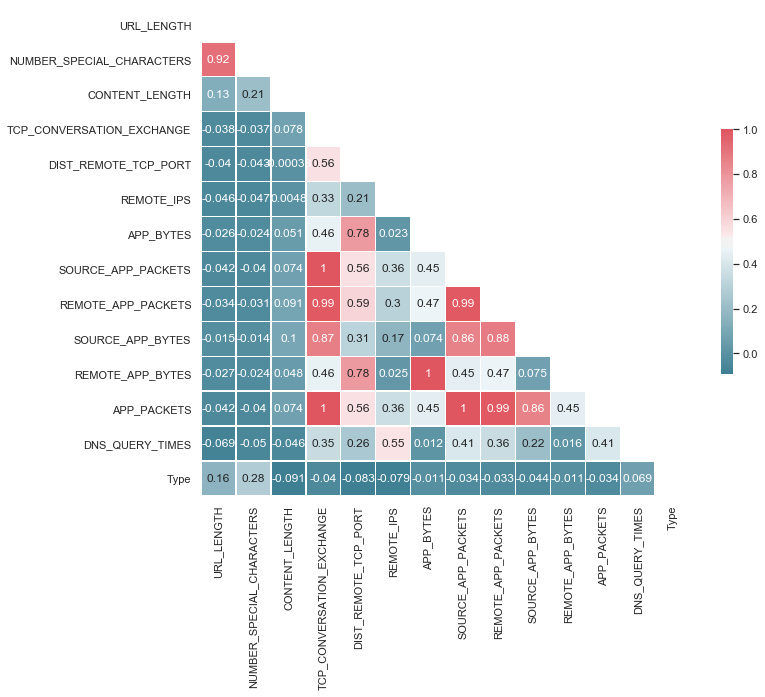

In [14]:
# create heatmap
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# generate a mask for the upper triangle
mask = np.zeros_like(websites_corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# set up the matplotlib figure
f, ax = plt.subplots(figsize=(11,9))

# generate a custom diverging colormap
cmap = sns.diverging_palette(220,10,as_cmap = True)

# draw the heatmap with the mask and correct aspect ration
sns.heatmap(websites_corr, mask = mask, cmap = cmap, center = 0.5,
           annot = True, square = True, linewidths=.5, cbar_kws={'shrink':.5})


In [16]:
# which columns to remove due to high collinearity?
'''
TCP_CONVERSATION_EXCHANGE, APP_PACKETS, REMOTE_APP_PACKETS, SOURCE_APP_PACKETS
have a correlation coefficient of 1 or arount 1
same with APP_BYTES and REMOTE_APP_BYTES
'''

'\nTCP_CONVERSATION_EXCHANGE, APP_PACKETS, REMOTE_APP_PACKETS, SOURCE_APP_PACKETS\nhave a correlation coefficient of 1 or arount 1\nsame with APP_BYTES and REMOTE_APP_BYTES\n'

# Challenge 2 - Remove Column Collinearity.

From the heatmap you created, you should have seen at least 3 columns that can be removed due to high collinearity. Remove these columns from the dataset.

Note that you should remove as few columns as you can. You don't have to remove all the columns at once. But instead, try removing one column, then produce the heatmap again to determine if additional columns should be removed. As long as the dataset no longer contains columns that are correlated for over 90%, you can stop. Also, keep in mind when two columns have high collinearity, you only need to remove one of them but not both.

In the cells below, remove as few columns as you can to eliminate the high collinearity in the dataset. Make sure to comment on your way so that the instructional team can learn about your thinking process which allows them to give feedback. At the end, print the heatmap again.

In [17]:
# drop column 'APP_PACKETS'
websites_drop = websites.drop( columns = ['TCP_CONVERSATION_EXCHANGE','REMOTE_APP_PACKETS','REMOTE_APP_BYTES','APP_PACKETS'])

In [18]:
# new correlation matrix without 'APP_PACKETS'
new_web_corr = websites_drop.corr()

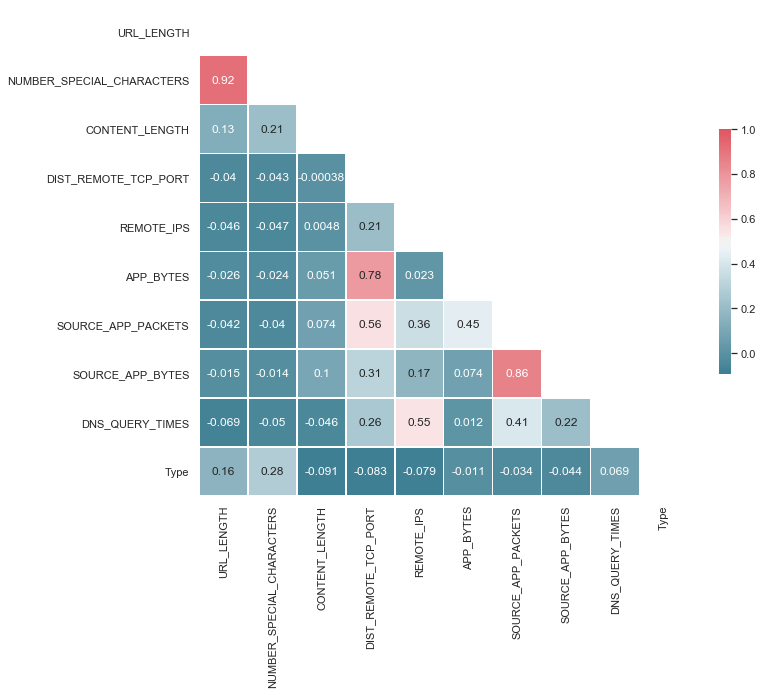

In [19]:
# Print heatmap again
sns.set(style="white")

# generate a mask for the upper triangle
mask = np.zeros_like(new_web_corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# set up the matplotlib figure
f, ax = plt.subplots(figsize=(11,9))

# generate a custom diverging colormap
cmap = sns.diverging_palette(220,10,as_cmap = True)

# draw the heatmap with the mask and correct aspect ration
sns.heatmap(new_web_corr, mask = mask, cmap = cmap, center = 0.5,
           annot = True, square = True, linewidths=.5, cbar_kws={'shrink':.5})

# Challenge 3 - Handle Missing Values

The next step would be handling missing values. **We start by examining the number of missing values in each column, which you will do in the next cell.**

In [20]:
# check for missing values
websites_drop.isnull().sum()

URL                            0
URL_LENGTH                     0
NUMBER_SPECIAL_CHARACTERS      0
CHARSET                        0
SERVER                         1
CONTENT_LENGTH               812
WHOIS_COUNTRY                  0
WHOIS_STATEPRO                 0
WHOIS_REGDATE                  0
WHOIS_UPDATED_DATE             0
DIST_REMOTE_TCP_PORT           0
REMOTE_IPS                     0
APP_BYTES                      0
SOURCE_APP_PACKETS             0
SOURCE_APP_BYTES               0
DNS_QUERY_TIMES                1
Type                           0
dtype: int64

If you remember in the previous labs, we drop a column if the column contains a high proportion of missing values. After dropping those problematic columns, we drop the rows with missing values.

#### In the cells below, handle the missing values from the dataset. Remember to comment the rationale of your decisions.

In [21]:
# proportion of NaN in CONTENT_LENGTH
websites_drop['CONTENT_LENGTH'].isna().sum() / len(websites_drop['CONTENT_LENGTH'])

0.45592363840539024

In [22]:
# Your comment here
'''
Almost half of the CONTENT_LENGTH column is missing values so I'll just drop
this column.
SERVER and DNS_QUERY_TIMES both contain 1 missing value so I'll just drop those
rows.
'''

"\nAlmost half of the CONTENT_LENGTH column is missing values so I'll just drop\nthis column.\nSERVER and DNS_QUERY_TIMES both contain 1 missing value so I'll just drop those\nrows.\n"

In [23]:
# drop column CONTENT_LENGTH
websites_drop.drop( columns = ['CONTENT_LENGTH'], inplace = True)

In [24]:
# drop NaN rows
websites_drop_nan = websites_drop.dropna(axis = 0)

#### Again, examine the number of missing values in each column. 

If all cleaned, proceed. Otherwise, go back and do more cleaning.

In [25]:
# Examine missing values in each column
websites_drop_nan.isnull().sum()

URL                          0
URL_LENGTH                   0
NUMBER_SPECIAL_CHARACTERS    0
CHARSET                      0
SERVER                       0
WHOIS_COUNTRY                0
WHOIS_STATEPRO               0
WHOIS_REGDATE                0
WHOIS_UPDATED_DATE           0
DIST_REMOTE_TCP_PORT         0
REMOTE_IPS                   0
APP_BYTES                    0
SOURCE_APP_PACKETS           0
SOURCE_APP_BYTES             0
DNS_QUERY_TIMES              0
Type                         0
dtype: int64

In [26]:
# no missing values, the show goes on

# Challenge 4 - Handle `WHOIS_*` Categorical Data

There are several categorical columns we need to handle. These columns are:

* `URL`
* `CHARSET`
* `SERVER`
* `WHOIS_COUNTRY`
* `WHOIS_STATEPRO`
* `WHOIS_REGDATE`
* `WHOIS_UPDATED_DATE`

How to handle string columns is always case by case. Let's start by working on `WHOIS_COUNTRY`. Your steps are:

1. List out the unique values of `WHOIS_COUNTRY`.
1. Consolidate the country values with consistent country codes. For example, the following values refer to the same country and should use consistent country code:
    * `CY` and `Cyprus`
    * `US` and `us`
    * `SE` and `se`
    * `GB`, `United Kingdom`, and `[u'GB'; u'UK']`

#### In the cells below, fix the country values as intructed above.

In [27]:
# list unique values in WHOIS_COUNTRY column
websites_drop_nan.WHOIS_COUNTRY.unique()

array(['None', 'US', 'SC', 'GB', 'UK', 'RU', 'AU', 'CA', 'PA', 'se', 'IN',
       'LU', 'TH', "[u'GB'; u'UK']", 'FR', 'NL', 'UG', 'JP', 'CN', 'SE',
       'SI', 'IL', 'ru', 'KY', 'AT', 'CZ', 'PH', 'BE', 'NO', 'TR', 'LV',
       'DE', 'ES', 'BR', 'us', 'KR', 'HK', 'UA', 'CH', 'United Kingdom',
       'BS', 'PK', 'IT', 'Cyprus', 'BY', 'AE', 'IE', 'UY', 'KG'],
      dtype=object)

In [28]:
# replace values in WHOIS_COUNTRY column
country_dict = {"Cyprus": 'CY', 'us': 'US',
                'se':'SE','GB':'UK',
                'United Kingdom':'UK',"[u'GB'; u'UK']":'UK',
               'ru':'RU'}

websites_countries_fixed = websites_drop_nan.replace({'WHOIS_COUNTRY':country_dict})

In [29]:
# check unique values
websites_countries_fixed.WHOIS_COUNTRY.unique()

array(['None', 'US', 'SC', 'UK', 'RU', 'AU', 'CA', 'PA', 'SE', 'IN', 'LU',
       'TH', 'FR', 'NL', 'UG', 'JP', 'CN', 'SI', 'IL', 'KY', 'AT', 'CZ',
       'PH', 'BE', 'NO', 'TR', 'LV', 'DE', 'ES', 'BR', 'KR', 'HK', 'UA',
       'CH', 'BS', 'PK', 'IT', 'CY', 'BY', 'AE', 'IE', 'UY', 'KG'],
      dtype=object)

In [30]:
len(websites_countries_fixed.WHOIS_COUNTRY.unique())

43

Since we have fixed the country values, can we convert this column to ordinal now?

Not yet. If you reflect on the previous labs how we handle categorical columns, you probably remember we ended up dropping a lot of those columns because there are too many unique values. Too many unique values in a column is not desirable in machine learning because it makes prediction inaccurate. But there are workarounds under certain conditions. One of the fixable conditions is:

#### If a limited number of values account for the majority of data, we can retain these top values and re-label all other rare values.

The `WHOIS_COUNTRY` column happens to be this case. You can verify it by print a bar chart of the `value_counts` in the next cell to verify:

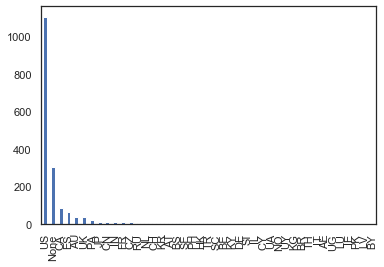

In [31]:
# WHOSIS_COUNTRY bar plot
y = websites_countries_fixed['WHOIS_COUNTRY'].value_counts()
y.plot.bar()
plt.show()

#### After verifying, now let's keep the top 10 values of the column and re-label other columns with `OTHER`.

In [32]:
# create list of labels
countries_not_replace = list(websites_countries_fixed['WHOIS_COUNTRY'].value_counts()[:10].index)
print(countries_not_replace)

['US', 'None', 'CA', 'ES', 'AU', 'UK', 'PA', 'JP', 'CN', 'IN']


In [33]:
# re-label countries name
websites_countries_fixed['WHOIS_COUNTRY'] = [i if i in countries_not_replace else 'OTHER' for i in websites_countries_fixed['WHOIS_COUNTRY']]

In [34]:
# re-check the unique country values
websites_countries_fixed.WHOIS_COUNTRY.unique()

array(['None', 'US', 'OTHER', 'UK', 'AU', 'CA', 'PA', 'IN', 'JP', 'CN',
       'ES'], dtype=object)

Now since `WHOIS_COUNTRY` has been re-labelled, we don't need `WHOIS_STATEPRO` any more because the values of the states or provinces may not be relevant any more. We'll drop this column.

In addition, we will also drop `WHOIS_REGDATE` and `WHOIS_UPDATED_DATE`. These are the registration and update dates of the website domains. Not of our concerns.

#### In the next cell, drop `['WHOIS_STATEPRO', 'WHOIS_REGDATE', 'WHOIS_UPDATED_DATE']`.

In [35]:
# drop columns that no longer make sense after re-labelling countries
drop_cols = ['WHOIS_STATEPRO', 'WHOIS_REGDATE', 'WHOIS_UPDATED_DATE']

websites_drop_states_dates = websites_countries_fixed.drop(columns = drop_cols)
websites_drop_states_dates.head()

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,WHOIS_COUNTRY,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,SOURCE_APP_BYTES,DNS_QUERY_TIMES,Type
0,M0_109,16,7,iso-8859-1,nginx,None,0,2,700,9,1153,2.0,1
1,B0_2314,16,6,UTF-8,Apache/2.4.10,None,7,4,1230,17,1265,0.0,0
2,B0_911,16,6,us-ascii,Microsoft-HTTPAPI/2.0,None,0,0,0,0,0,0.0,0
3,B0_113,17,6,ISO-8859-1,nginx,US,22,3,3812,39,18784,8.0,0
4,B0_403,17,6,UTF-8,None,US,2,5,4278,61,129889,4.0,0


# Challenge 5 - Handle Remaining Categorical Data & Convert to Ordinal

Now print the `dtypes` of the data again. Besides `WHOIS_COUNTRY` which we already fixed, there should be 3 categorical columns left: `URL`, `CHARSET`, and `SERVER`.

In [36]:
# check dtypes again
websites_drop_states_dates.dtypes

URL                           object
URL_LENGTH                     int64
NUMBER_SPECIAL_CHARACTERS      int64
CHARSET                       object
SERVER                        object
WHOIS_COUNTRY                 object
DIST_REMOTE_TCP_PORT           int64
REMOTE_IPS                     int64
APP_BYTES                      int64
SOURCE_APP_PACKETS             int64
SOURCE_APP_BYTES               int64
DNS_QUERY_TIMES              float64
Type                           int64
dtype: object

#### `URL` is easy. We'll simply drop it because it has too many unique values that there's no way for us to consolidate.

In [37]:
# drop URL columns
websites_drop_URL = websites_drop_states_dates.drop(columns ='URL')

#### Print the unique value counts of `CHARSET`. You see there are only a few unique values. So we can keep it as it is.

In [38]:
# CHARSET unique values
websites_drop_URL['CHARSET'].unique()

array(['iso-8859-1', 'UTF-8', 'us-ascii', 'ISO-8859-1', 'utf-8', 'None',
       'windows-1251', 'ISO-8859', 'windows-1252'], dtype=object)

`SERVER` is a little more complicated. Print its unique values and think about how you can consolidate those values.

#### Before you think of your own solution, don't read the instructions that come next.

In [39]:
# SERVER unique values
websites_drop_URL['SERVER'].unique()

array(['nginx', 'Apache/2.4.10', 'Microsoft-HTTPAPI/2.0', 'None',
       'Apache/2', 'nginx/1.10.1', 'Apache', 'Apache/2.2.15 (Red Hat)',
       'Apache/2.4.23 (Unix) OpenSSL/1.0.1e-fips mod_bwlimited/1.4',
       'openresty/1.11.2.1', 'Apache/2.2.22', 'Apache/2.4.7 (Ubuntu)',
       'nginx/1.12.0',
       'Apache/2.4.12 (Unix) OpenSSL/1.0.1e-fips mod_bwlimited/1.4',
       'Oracle-iPlanet-Web-Server/7.0', 'cloudflare-nginx', 'nginx/1.6.2',
       'openresty', 'Heptu web server', 'Pepyaka/1.11.3', 'nginx/1.8.0',
       'nginx/1.10.1 + Phusion Passenger 5.0.30',
       'Apache/2.2.29 (Amazon)', 'Microsoft-IIS/7.5', 'LiteSpeed',
       'Apache/2.4.25 (cPanel) OpenSSL/1.0.1e-fips mod_bwlimited/1.4',
       'tsa_c', 'Apache/2.2.0 (Fedora)', 'Apache/2.2.22 (Debian)',
       'Apache/2.2.15 (CentOS)', 'Apache/2.4.25',
       'Apache/2.4.25 (Amazon) PHP/7.0.14', 'GSE',
       'Apache/2.4.23 (Unix) OpenSSL/0.9.8e-fips-rhel5 mod_bwlimited/1.4',
       'Apache/2.4.25 (Amazon) OpenSSL/1.0.1k-fips'

![Think Hard](../images/think-hard.jpg)

In [40]:
# Your comment here
'''
After a general overview, maybe I can aggregate by 'Microsoft', 'Apache' and
so on.
'''

"\nAfter a general overview, maybe I can aggregate by 'Microsoft', 'Apache' and\nso on.\n"

Although there are so many unique values in the `SERVER` column, there are actually only 3 main server types: `Microsoft`, `Apache`, and `nginx`. Just check if each `SERVER` value contains any of those server types and re-label them. For `SERVER` values that don't contain any of those substrings, label with `Other`.

At the end, your `SERVER` column should only contain 4 unique values: `Microsoft`, `Apache`, `nginx`, and `Other`.

In [41]:
# re-label SERVER

#server_labels = ['Microsoft','Apache','nginx']
#websites_drop_URL['SERVER'] = [i if websites_drop_URL['SERVER'].str.contains('%i%') else 'OTHER' for i in server_labels]

websites_drop_URL['SERVER'] = ['Microsoft' if i.startswith('mw') else 'Apache' if i.startswith('Apache') else 'nginx' if i.startswith('nginx') else 'Other' for i in websites_drop_URL['SERVER']]

# is there a more elegant way to do this?

In [42]:
# Count `SERVER` value counts here
websites_drop_URL['SERVER'].value_counts()

Other        736
Apache       641
nginx        341
Microsoft     61
Name: SERVER, dtype: int64

OK, all our categorical data are fixed now. **Let's convert them to ordinal data using Pandas' `get_dummies` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)).** Make sure you drop the categorical columns by passing `drop_first=True` to `get_dummies` as we don't need them any more. **Also, assign the data with dummy values to a new variable `website_dummy`.**

In [43]:
# Your code here
website_dummy = pd.get_dummies(websites_drop_URL, drop_first=True)

Now, inspect `website_dummy` to make sure the data and types are intended - there shouldn't be any categorical columns at this point.

In [44]:
# Your code here
website_dummy.dtypes

URL_LENGTH                     int64
NUMBER_SPECIAL_CHARACTERS      int64
DIST_REMOTE_TCP_PORT           int64
REMOTE_IPS                     int64
APP_BYTES                      int64
SOURCE_APP_PACKETS             int64
SOURCE_APP_BYTES               int64
DNS_QUERY_TIMES              float64
Type                           int64
CHARSET_ISO-8859-1             uint8
CHARSET_None                   uint8
CHARSET_UTF-8                  uint8
CHARSET_iso-8859-1             uint8
CHARSET_us-ascii               uint8
CHARSET_utf-8                  uint8
CHARSET_windows-1251           uint8
CHARSET_windows-1252           uint8
SERVER_Microsoft               uint8
SERVER_Other                   uint8
SERVER_nginx                   uint8
WHOIS_COUNTRY_CA               uint8
WHOIS_COUNTRY_CN               uint8
WHOIS_COUNTRY_ES               uint8
WHOIS_COUNTRY_IN               uint8
WHOIS_COUNTRY_JP               uint8
WHOIS_COUNTRY_None             uint8
WHOIS_COUNTRY_OTHER            uint8
W

# Challenge 6 - Modeling, Prediction, and Evaluation

We'll start off this section by splitting the data to train and test. **Name your 4 variables `X_train`, `X_test`, `y_train`, and `y_test`. Select 80% of the data for training and 20% for testing.**

In [45]:
from sklearn.model_selection import train_test_split

# drop the target column
X = website_dummy.drop(['Type'], axis =1)

# assign the target column
y = website_dummy['Type']

# splitting the data to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=29)

# what's the criterion to define random state?

#### In this lab, we will try two different models and compare our results.

The first model we will use in this lab is logistic regression. We have previously learned about logistic regression as a classification algorithm. In the cell below, load `LogisticRegression` from scikit-learn and initialize the model.

In [46]:
# load logistic regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

Next, fit the model to our training data. We have already separated our data into 4 parts. Use those in your model.

In [52]:
# Your code here:
lr.fit(X_train, y_train)
acc = lr.score(X_test,y_test) * 100

print(f"Logistic Regression Test Accuracy {round(acc, 2)}%")

Logistic Regression Test Accuracy 93.54%


C:\Nane\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finally, import `confusion_matrix` and `accuracy_score` from `sklearn.metrics` and fit our testing data. Assign the fitted data to `y_pred` and print the confusion matrix as well as the accuracy score

In [53]:
# import libraries
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [54]:
# assign y_test
y_pred_lr = lr.predict(X_test)

In [55]:
# print the correlation matrix
confusion_matrix(y_test, y_pred_lr)

array([[309,   6],
       [ 17,  24]], dtype=int64)

In [56]:
# print accuracy_score
accuracy_score(y_test, y_pred_lr)

0.9353932584269663

What are your thoughts on the performance of the model? Write your conclusions below.

In [ ]:
# Your conclusions here:
'''
I think the model has a good performance.
The accuracy is high and also the true positive values is high.
Neverthless, in the negatives row, the false and true values are quite similar.
'''


#### Our second algorithm is is K-Nearest Neighbors. 

Though is it not required, we will fit a model using the training data and then test the performance of the model using the testing data. Start by loading `KNeighborsClassifier` from scikit-learn and then initializing and fitting the model. We'll start off with a model where k=3.

In [58]:
# KNN model
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 3) # initialize the model
knn.fit(X_train, y_train) # fit the model using the training data

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

To test your model, compute the predicted values for the testing sample and print the confusion matrix as well as the accuracy score.

In [64]:
# test the model using the testing data and accurancy score
acc_KNN = knn.score(X_test, y_test) * 100
print(f"3 neighbors KNN Score: {round(acc,2)}%")

3 neighbors KNN Score: 93.54%


In [65]:
# assign y_test
y_pred_knn = knn.predict(X_test)

In [66]:
# print the correlation matrix
confusion_matrix(y_test, y_pred_knn)

array([[301,  14],
       [  8,  33]], dtype=int64)

In [67]:
# print accuracy_score
accuracy_score(y_test, y_pred_knn)

0.9382022471910112

#### We'll create another K-Nearest Neighbors model with k=5. 

Initialize and fit the model below and print the confusion matrix and the accuracy score.

In [69]:
knn_5 = KNeighborsClassifier(n_neighbors = 5) # initialize the model
knn_5.fit(X_train, y_train) # fit the model using the training data

# test the model using the testing data and accurancy score
acc_KNN = knn_5.score(X_test, y_test) * 100
print(f"5 neighbors KNN Score: {round(acc,2)}%")

5 neighbors KNN Score: 93.54%


In [72]:
# assign y_test
y_pred_knn_5 = knn_5.predict(X_test)

In [73]:
# print the correlation matrix
confusion_matrix(y_test, y_pred_knn_5)

array([[309,   6],
       [ 11,  30]], dtype=int64)

In [74]:
# print accuracy_score
accuracy_score(y_test, y_pred_knn_5)

0.952247191011236

Did you see an improvement in the confusion matrix when increasing k to 5? Did you see an improvement in the accuracy score? Write your conclusions below.

In [75]:
# Your conclusions here:
'''
There is an improvement in the confusion matrix and it is more true positives
and negatives and also less false negatives.
Accuracy also improved about 2%.
'''

'\nThere is an improvement in the confusion matrix and it is more true positives\nand negatives and also less false negatives.\nAccuracy also improved about 2%.\n'

# Bonus Challenge - Feature Scaling

Problem-solving in machine learning is iterative. You can improve your model prediction with various techniques (there is a sweetspot for the time you spend and the improvement you receive though). Now you've completed only one iteration of ML analysis. There are more iterations you can conduct to make improvements. In order to be able to do that, you will need deeper knowledge in statistics and master more data analysis techniques. In this bootcamp, we don't have time to achieve that advanced goal. But you will make constant efforts after the bootcamp to eventually get there.

However, now we do want you to learn one of the advanced techniques which is called *feature scaling*. The idea of feature scaling is to standardize/normalize the range of independent variables or features of the data. This can make the outliers more apparent so that you can remove them. This step needs to happen during Challenge 6 after you split the training and test data because you don't want to split the data again which makes it impossible to compare your results with and without feature scaling. For general concepts about feature scaling, click [here](https://en.wikipedia.org/wiki/Feature_scaling). To read deeper, click [here](https://medium.com/greyatom/why-how-and-when-to-scale-your-features-4b30ab09db5e).

In the next cell, attempt to improve your model prediction accuracy by means of feature scaling. A library you can utilize is `sklearn.preprocessing.RobustScaler` ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html)). You'll use the `RobustScaler` to fit and transform your `X_train`, then transform `X_test`. You will use logistic regression to fit and predict your transformed data and obtain the accuracy score in the same way. Compare the accuracy score with your normalized data with the previous accuracy data. Is there an improvement?

In [76]:
# import libraries
from sklearn.preprocessing import RobustScaler

In [83]:
# fit and transform X_train and X_test
transformer_train = RobustScaler().fit_transform(X_train)
transformer_test = RobustScaler().fit_transform(X_test)

In [85]:
# apply logistic regression model
lr.fit(transformer_train, y_train)
acc = lr.score(transformer_test,y_test) * 100

print(f"Logistic Regression Test Accuracy {round(acc, 2)}%")

Logistic Regression Test Accuracy 93.82%


C:\Nane\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [87]:
# before it was 93.54%, so it improved

In [86]:
y_pred_lr_FS = lr.predict(transformer_test)

In [88]:
# print the correlation matrix
confusion_matrix(y_test, y_pred_lr_FS)

array([[305,  10],
       [ 12,  29]], dtype=int64)

In [89]:
# now I have less TP and more TN